# [IAPR][iapr]: Lab 2 ‒  Object description

**Group ID:** 37

**Author 1 (sciper):** Michael Biselx    (283812)  
**Author 2 (sciper):** Bastien Darbellay (288406)   
**Author 3 (sciper):** Maria   Guerraoui (274578)  

**Release date:** 25.03.2022  
**Due date:** 08.04.2022 (11:59 pm)


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as
preparation for the final project, which is a practical project which ties together the topics of the course.

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external
functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation
in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook <font color='red'> rerun </font>the notebook from scratch !**
`Kernel` > `Restart & Run All`

We will not rerun the notebook for you.


[iapr]: https://github.com/LTS5/iapr

---
## 0. Extract relevant data
We first need to extract the `lab-02-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
data_part1 = os.path.join(data_base_path, data_folder, 'part1')
data_part2 = os.path.join(data_base_path, data_folder, 'part2')

tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

---
## Part 1
In the `lab-02-data/part1` folder, you will find 28x28 grey-scale pictures of handwritten "0" and "1".
These digits have been extracted from MNIST dataset (http://yann.lecun.com/exdb/mnist/).

Your goal is to extract, from each of those images, a 2-dimensional feature vector (i.e. 2 features) and to plot them all on a 2D graph.
If you have chosen good features, the vectors of the "0"'s should nicely cluster in one part of the plane and those of the "1"'s in another.

Please try:
1. Fourier Descriptors (15pts). 
    1. Implementation (10 pts).
    2. Showing invariance to rotation, translation and scaling (5 pts).
2. Additional method of your choice (5 pts)


**Note:** for the Fourier descriptors, the u_k signal has to be constructed by following the contour point after point. Some pre-processing (image binarization, possibly some Mathematical Morphology) might be useful.

### 1.1 Data visualization

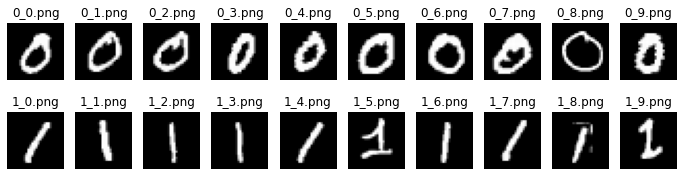

In [2]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

def load(path, digit='0'):
    digit_path = os.path.join(path, digit)
    digit_names = [nm for nm in os.listdir(digit_path) if '.png' in nm]  # make sure to only load .png
    digit_names.sort()  # sort file names
    ic = skimage.io.imread_collection([os.path.join(digit_path, nm) for nm in digit_names])
    digit_im = skimage.io.concatenate_images(ic)
    return digit_im, digit_names
                        
#  Load zeros and ones
zeros_im, zeros_names = load(data_part1, digit='0')
ones_im, ones_names = load(data_part1, digit='1')


# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 1.2 Fourier descriptors (15 pts)

#### A - Zeros and Ones - Implementation

In [8]:
# Add your implementation and discussion
import skimage.measure
import skimage.transform
import numpy as np

def get_fourier_descriptors(img, nb_descr=2, descr_idx=[]) : 
    # step 1 : extract longest continuous contour in the image
    all_cont  = skimage.measure.find_contours(img, 0.5*img.max())
    long_cont = max(all_cont, key=len)

    # step 2 : fourier transform of the contour
    fft_cont = np.fft.fft(long_cont[:,0] + long_cont[:,1]*1j)

    # step 3 : get the interesting indices 
    if len(descr_idx) : # if indices of descriptors are specified 
        descr_idx = np.append(descr_idx, 0) # add the idx '0' for the contour aproximation
    else :              # otherwise take the nb_descr lowest frequencies
        descr_idx = np.arange(-np.floor(nb_descr/2), np.ceil(nb_descr/2)+1, dtype=int)
    aprx_cont = np.zeros_like(fft_cont)       # make a contour approximation for visualization
    aprx_cont[descr_idx] = fft_cont[descr_idx];
    aprx_cont = np.fft.ifft(aprx_cont)
    
    # step 4 : extract the relevant descriptors 
    descr_idx   = np.delete(descr_idx, descr_idx==0) # remove the idx '0'
    descriptors = fft_cont[descr_idx]
    
    # step 5 : normalize descriptors onto the unit ball
    #descriptors = np.abs(descriptors) / np.linalg.norm(descriptors)     # normalize over descriptors 
    descriptors = np.abs(descriptors) / np.linalg.norm(fft_cont[1:])     # normalize over the entire fft
    
    return descriptors, aprx_cont


def apply_random_transform(img) :
    translation = -2 + 4*np.random.random((1,2)) # translation = [-2  - +2]
    rotation = 360*np.random.random()            # rotation    = [0°  - 360°]
    scale = 0.9 + 0.2*np.random.random(1)        # scale       = [0.9 - 1.1]
    tform = skimage.transform.SimilarityTransform(scale=1/scale, translation=translation)
    
    img_r = skimage.transform.rotate(img, rotation, order=3)
    img_t = skimage.transform.warp(img_r, tform, order=3) # don't use rotation, bc it's weird
    
    return img_t


def plot_imgs_and_contours(axes, images, names, contours, opt) : 
    for ax, im, nm, cnt in zip(axes, images, names, contours):
        ax.imshow(im, cmap='gray')
        ax.plot(cnt.imag, cnt.real, opt)
        ax.axis('off')
        ax.set_title(nm)
        
        
def plot_descriptors(ax, descriptors, opt, label="") :
    ax.plot(descriptors[:,0], descriptors[:,1], opt, label=label)
    ax.set_xlabel("descriptor 1")
    ax.set_ylabel("descriptor 2")
    ax.axis('equal')
    ax.legend()

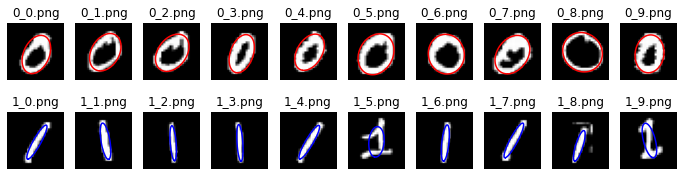

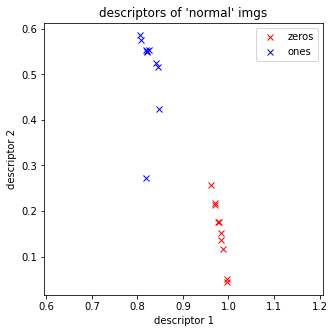

In [4]:
#Fourier descriptors
nb_dscr = 2

# do the operation on the 'normal' images 
out_0 = list(zip(*[(get_fourier_descriptors(img, nb_dscr)) for img in zeros_im]))
descriptors_0, contours_0 = np.array(out_0[0]), out_0[1]
out_1 = list(zip(*[(get_fourier_descriptors(img, nb_dscr)) for img in ones_im]))
descriptors_1, contours_1 = np.array(out_1[0]), out_1[1]

# plot images with descriptors
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
plot_imgs_and_contours(axes[0], zeros_im, zeros_names, contours_0, 'r')
plot_imgs_and_contours(axes[1], ones_im,  ones_names,  contours_1, 'b')

# plot descriptors 
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
plot_descriptors(ax, descriptors_0, 'rx', "zeros") 
plot_descriptors(ax, descriptors_1, 'bx', "ones") 
plt.title("descriptors of 'normal' imgs")

plt.show()

# one can clearly see the separation between the ones and the zeros 
# in the desciptor space, which arises from the different shapes of 
# the contours (the zeros being rather round, thus mostly being 
# comprised of a single descriptor, wheras the ones need two descriptors
# to approximate their elongated shapes a bit better. 
# The exceptions are 1_5 and 1_9, which have extra bits. This causes 
# them to be outliers from the main cluster.

#### B - Zeros and Ones - Showing invariance to rotation, translation and scaling

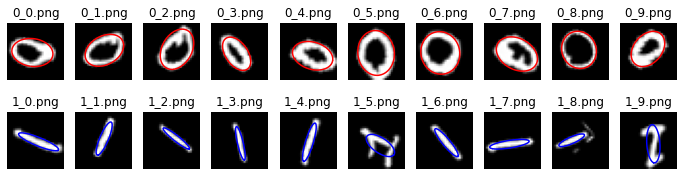

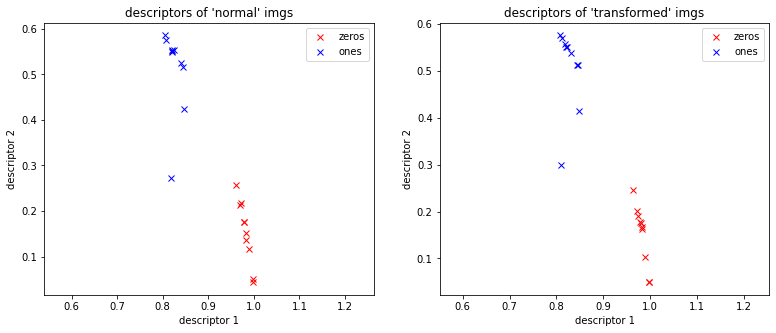

In [10]:
# GOAL : demonstrate the invariance to random transformation 

# apply a random transformation (rotation + scale + translation) to images
zeros_im_t = [apply_random_transform(im) for im in zeros_im]
ones_im_t  = [apply_random_transform(im) for im in ones_im]

# get descriptors for the transformed images
out_0t = list(zip(*[(get_fourier_descriptors(img, nb_dscr)) for img in zeros_im_t]))
descriptors_0t, contours_0t = np.array(out_0t[0]), out_0t[1]
out_1t = list(zip(*[(get_fourier_descriptors(img, nb_dscr)) for img in ones_im_t]))
descriptors_1t, contours_1t = np.array(out_1t[0]), out_1t[1]


# plot transformed images & contours
fig, axes = plt.subplots(2, len(zeros_im_t), figsize=(12, 3))
plot_imgs_and_contours(axes[0], zeros_im_t, zeros_names, contours_0t, 'r')
plot_imgs_and_contours(axes[1], ones_im_t,  ones_names,  contours_1t, 'b')

    
# plot descriptors of normal images to compare with ...
fig, axes = plt.subplots(1, 2, figsize=(13, 5))
plot_descriptors(axes[0], descriptors_0, 'rx', "zeros") 
plot_descriptors(axes[0], descriptors_1, 'bx', "ones") 
axes[0].set_title("descriptors of 'normal' imgs")

# plot descriptors of transformed images 
plot_descriptors(axes[1], descriptors_0t, 'rx', "zeros") 
plot_descriptors(axes[1], descriptors_1t, 'bx', "ones") 
axes[1].set_title("descriptors of 'transformed' imgs")


plt.show()

# While at first glance it does appear to be tranformation invariant, 
# upon closer inspection, one can see that the descriptors are not 
# completely invariant under transformation. 
# This is due to the translations, which can sometimes drop parts of the 
# number outside the image area, resulting in an incomplete contour detection. 
# Additionally, the blurring due to the interpolation in the image 
# transformation can also cause some 'changes' in the detected contours, 
# reducing the energy in higher frequencies
#
# That being said, it's close enough to clearly be able to separate the classes. 

### 1.3 Additional method (5 pts)

In [11]:
def PolyArea(contour):
    # Compute area of a polygon
    return 0.5*np.abs(np.dot(contour[:,0],np.roll(contour[:,1],1))-np.dot(contour[:,1],np.roll(contour[:,0],1)))

def GetSurfaceArea(contour, shape="rectangle"):
    # Compute the area of the numbers while approximating them by "shape"
    if shape == "rectangle":
        w = max(contour[:,0])-min(contour[:,0])
        h = max(contour[:,1])-min(contour[:,1])
        A = h*w
    elif shape == "ellipse":
        w = max(contour[:,0])-min(contour[:,0])
        h = max(contour[:,1])-min(contour[:,1])
        A = h*w*np.pi
    return A
        

def GetRatios(images, shape="rectangle"):
    # return ratio of contour area over "shape" area
    ratios = []
    for img in images:
        contour = max(skimage.measure.find_contours(img, level=0.5*img.max()), key=len)
        A = GetSurfaceArea(contour, shape)
        P = PolyArea(contour)
        ratios.append(P/A)
    return ratios

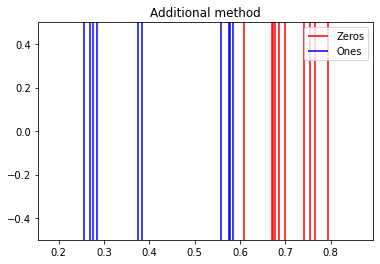

In [12]:
# Add your implementation and discussion
shape = "rectangle"
zeros_ratios = GetRatios(zeros_im, shape)
ones_ratios = GetRatios(ones_im, shape)

# plot figure
xmax = max(ones_ratios+zeros_ratios)+0.1
xmin = min(ones_ratios+zeros_ratios)-0.1
plt.figure()
plt.xlim(xmin,xmax)
plt.ylim(-0.5,0.5)
plt.eventplot(zeros_ratios, orientation='horizontal', lineoffset=0, colors='r', label='Zeros')
plt.eventplot(ones_ratios,  orientation='horizontal', lineoffset=0, colors='b', label='Ones')
plt.title("Additional method")
plt.axis('on')
plt.legend()
plt.show()

# We can see that for those examples a single descriptor is enough to classify zeros and ones. However, this only
# works with 1 and 0 since the area of the 0 not only includes the white line but also the black center. Therefore,
# compared to the 1, the ratio is bigger. This method would not work that well when comparing twos to threes.

---
## Part 2
The `lab-02-data/part2` folder contains grey-scale pictures of handwritten "2" and "3".
Extract the same feature (typically 2 Fourier descriptors) as in part 1 also on these images and plot them on the same graph as the features of the "0" and "1".
Is it possible to discriminate all these 4 digits with a 2-dimensional feature vector?

### 2.1 Data visualization

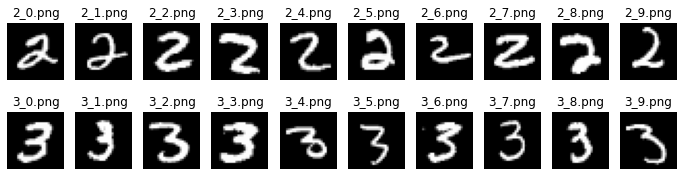

In [14]:
# Load twos and threes
twos_im, twos_names = load(data_part2, digit='2')
threes_im, threes_names = load(data_part2, digit='3')

# Plot images
fig, axes = plt.subplots(2, len(twos_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], twos_im, twos_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], threes_im, threes_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 2.2 Fourier descriptors - 4 digits (10 pts)

#### A - Twos and Threes - Implementation

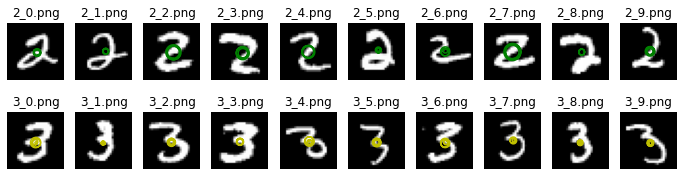

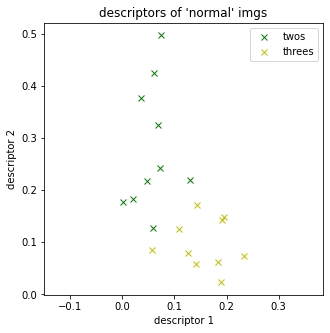

In [18]:
#Fourier descriptors
idx = np.array([-4, -3]) # heuristically found descriptors that allow the differentiation between 2 & 3

# do the operation on the 'normal' images 
out_2 = list(zip(*[(get_fourier_descriptors(img, descr_idx=idx)) for img in twos_im]))
descriptors_2, contours_2 = np.array(out_2[0]), out_2[1]
out_3 = list(zip(*[(get_fourier_descriptors(img, descr_idx=idx)) for img in threes_im]))
descriptors_3, contours_3 = np.array(out_3[0]), out_3[1]

# plot images with descriptors
fig, axes = plt.subplots(2, len(twos_im), figsize=(12, 3))
plot_imgs_and_contours(axes[0], twos_im,   twos_names,   contours_2, 'g')
plot_imgs_and_contours(axes[1], threes_im, threes_names, contours_3, 'y')

# plot descriptors 
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
plot_descriptors(ax, descriptors_2, 'gx', "twos") 
plot_descriptors(ax, descriptors_3, 'yx', "threes") 
plt.title("descriptors of 'normal' imgs")


plt.show()

# since the main shape of the two numbers is similar (vaguely oval-ish), these
# low-frequency descriptors are not very useful
# it is possible to find a set of 2 descriptors, which permit the differentiation of 
# twos and threes. For this, we need to look in the mid-level frequencies
# which is where much of the information on detailed contour hides. 

#### B - Twos and Threes - Showing invariance to rotation, translation and scaling

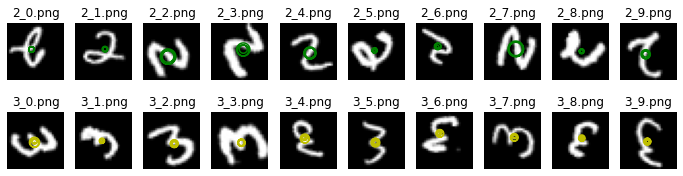

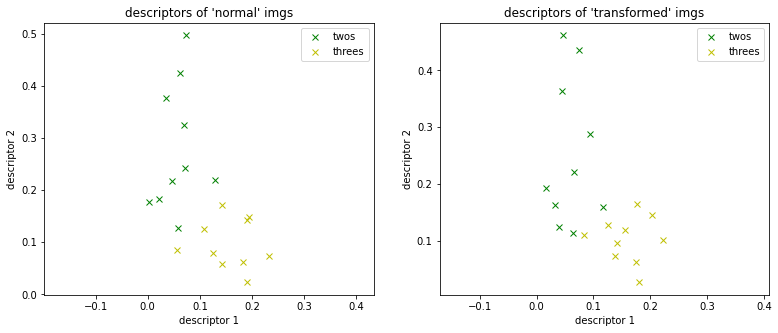

In [19]:
# GOAL : demonstrate the invariance to random transformation 

# apply a random transformation (rotation + scale + translation) to images
twos_im_t   = [apply_random_transform(im) for im in twos_im]
threes_im_t = [apply_random_transform(im) for im in threes_im]

# get descriptors for the transformed images
out_2t = list(zip(*[(get_fourier_descriptors(img, descr_idx=idx)) for img in twos_im_t]))
descriptors_2t, contours_2t = np.array(out_2t[0]), out_2t[1]
out_3t = list(zip(*[(get_fourier_descriptors(img, descr_idx=idx)) for img in threes_im_t]))
descriptors_3t, contours_3t = np.array(out_3t[0]), out_3t[1]

# plot transformed images 
fig, axes = plt.subplots(2, len(twos_im), figsize=(12, 3))
plot_imgs_and_contours(axes[0], twos_im_t,   twos_names,   contours_2t, 'g')
plot_imgs_and_contours(axes[1], threes_im_t, threes_names, contours_3t, 'y')


# plot descriptors of normal images to compare with ...
fig, axes = plt.subplots(1, 2, figsize=(13, 5))
plot_descriptors(axes[0], descriptors_2, 'gx', "twos") 
plot_descriptors(axes[0], descriptors_3, 'yx', "threes") 
axes[0].set_title("descriptors of 'normal' imgs")

# plot descriptors of transformed images 
plot_descriptors(axes[1], descriptors_2t, 'gx',"twos") 
plot_descriptors(axes[1], descriptors_3t, 'yx', "threes") 
axes[1].set_title("descriptors of 'transformed' imgs")

plt.show()

# again, one can see that the descriptors are not completely invariant
# under transformation. however, it is close enough to draw a rough
# separation line

#### C - 4 Digits

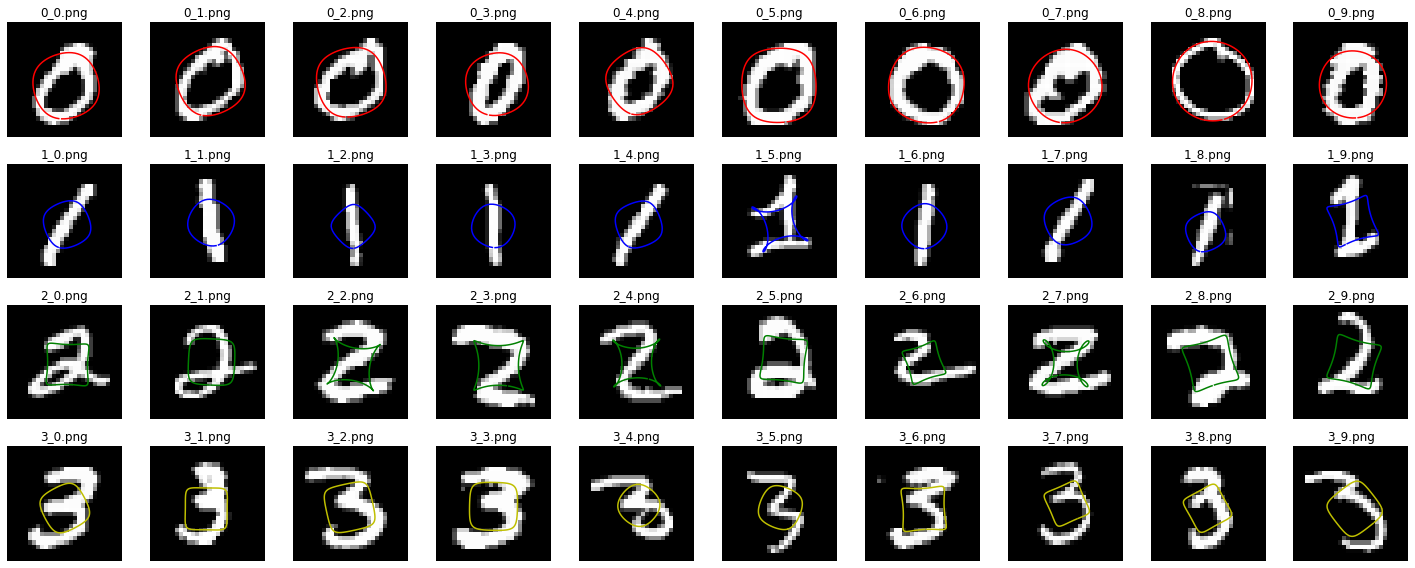

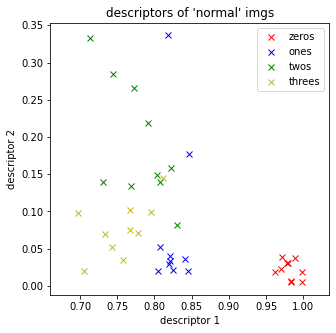

In [24]:
#USING INDEXES

#we have now our 4 digits
#idx = np.array([-4, -3])
#idx = np.array([ 3,  5])
idx = np.array([-1, 3])

# do the operation on the 'normal' images 
out_0 = list(zip(*[(get_fourier_descriptors(img, descr_idx=idx)) for img in zeros_im]))
descriptors_0, contours_0 = np.array(out_0[0]), out_0[1]
out_1 = list(zip(*[(get_fourier_descriptors(img, descr_idx=idx)) for img in ones_im]))
descriptors_1, contours_1 = np.array(out_1[0]), out_1[1]
out_2 = list(zip(*[(get_fourier_descriptors(img, descr_idx=idx)) for img in twos_im]))
descriptors_2, contours_2 = np.array(out_2[0]), out_2[1]
out_3 = list(zip(*[(get_fourier_descriptors(img, descr_idx=idx)) for img in threes_im]))
descriptors_3, contours_3 = np.array(out_3[0]), out_3[1]


# plot images with descriptors
fig, axes = plt.subplots(4, len(zeros_im), figsize=(20, 8))
plot_imgs_and_contours(axes[0], zeros_im,  zeros_names,  contours_0, 'r')
plot_imgs_and_contours(axes[1], ones_im,   ones_names,   contours_1, 'b')
plot_imgs_and_contours(axes[2], twos_im,   twos_names,   contours_2, 'g')
plot_imgs_and_contours(axes[3], threes_im, threes_names, contours_3, 'y')

fig.tight_layout()
    
# plot descriptors 
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
plot_descriptors(ax, descriptors_0, 'rx',"zeros") 
plot_descriptors(ax, descriptors_1, 'bx', "ones") 
plot_descriptors(ax, descriptors_2, 'gx', "twos") 
plot_descriptors(ax, descriptors_3, 'yx', "threes") 
plt.title("descriptors of 'normal' imgs")

plt.show()

# as expected, it is very hard to find something which permits a good separation between
# all four numbers. if one is willing to err on the side of overfitting the given 
# dataset, it might be possible to do so with the proposed descriptors with index [-1, 3]
# The price to pay is the two odd ones, which will be categorized as twos. 